In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# !pip3 install torchvision
from torchvision import datasets, transforms
from torch.nn.functional import cross_entropy

import json

import pickle

import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from samwrapper import sam
# import train
from samwrapper.example.model.smooth_cross_entropy import smooth_crossentropy
from torch.nn.utils import clip_grad_norm_

import concurrent.futures
from torch.optim.lr_scheduler import CyclicLR

from torch.autograd import Variable
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
def create_permuted_data(original_dataset, num_tasks=50):
    permuted_datasets = []
    for i in range(num_tasks):
        data = torch.tensor(original_dataset.data)
        targets = torch.tensor(original_dataset.targets)

        perm = torch.randperm(28*28)

        data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)
        permuted_datasets.append((data_permuted, targets))
    return permuted_datasets

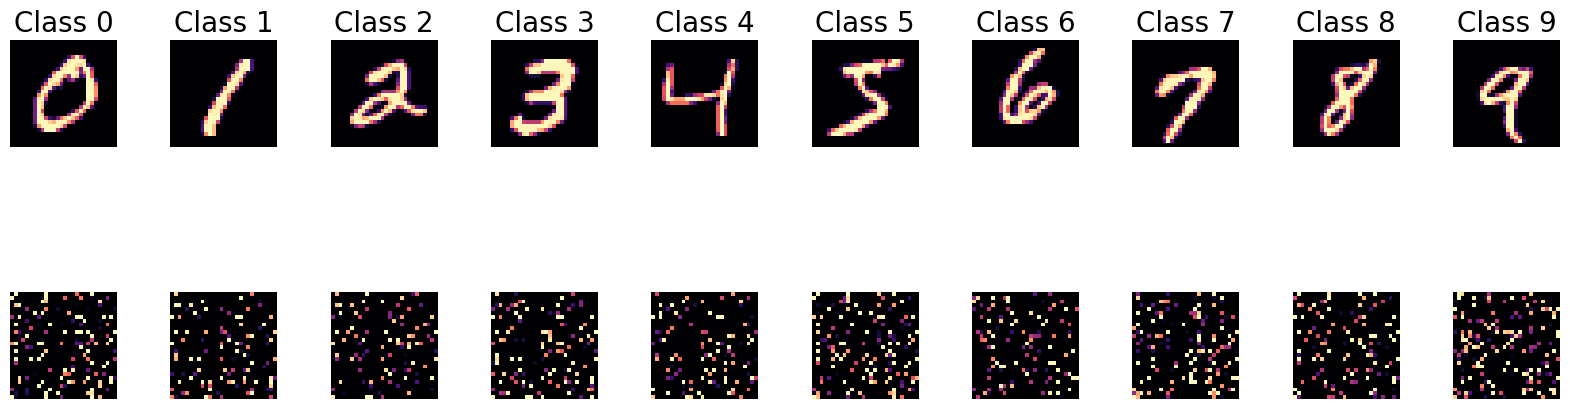

In [22]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
data = original_dataset.data.clone().detach()
targets = original_dataset.targets.clone().detach()
perm = torch.randperm(28*28)
data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)

class_examples = []
for i in range(10):
  class_indices = (targets == i).nonzero(as_tuple=True)[0]
  class_example = data[class_indices[0]]
  class_examples.append(class_example)

fig, axs = plt.subplots(2, 10, figsize=(20, 6))

for i in range(10):
  axs[0, i].imshow(class_examples[i], cmap='magma')
  axs[0, i].set_title(f'Class {i}', fontsize=20)
  axs[0, i].axis('off')

for i in range(10):
  axs[1, i].imshow(data_permuted[class_indices[i]], cmap='magma')
  axs[1, i].axis('off')

plt.subplots_adjust(wspace=0.5)


# plt.tight_layout()
plt.savefig('permuted_mnist.png', transparent=True)
plt.show()

IndexError: index 9 is out of bounds for axis 1 with size 9

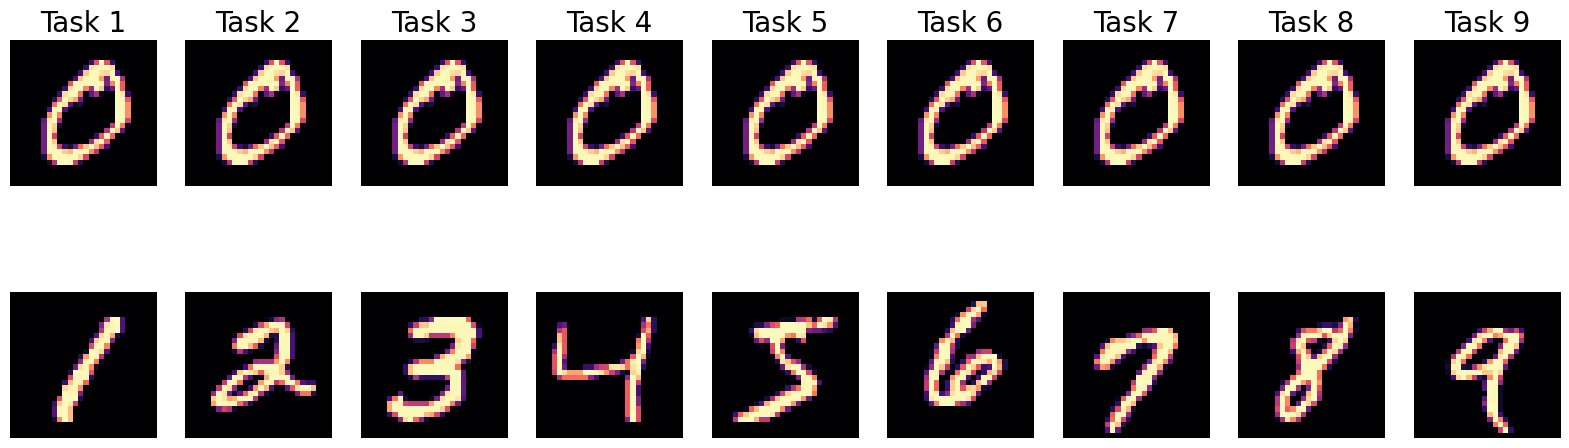

In [18]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
data = original_dataset.data.clone().detach()
targets = original_dataset.targets.clone().detach()
perm = torch.randperm(28*28)
data_permuted = data.view(-1, 28*28)[:, perm].view(-1, 28, 28)

class_examples = []
for i in range(10):
  class_indices = (targets == i).nonzero(as_tuple=True)[0]
  class_example = data[class_indices[0]]
  class_examples.append(class_example)

fig, axs = plt.subplots(2, 9, figsize=(20, 6))

for i in range(9):
  axs[0, i].imshow(class_examples[0], cmap='magma')
  axs[0, i].set_title(f'Task {i+1}', fontsize=20)
  axs[0, i].axis('off')

for i in range(10):
  axs[1, i].imshow(class_examples[i+1], cmap='magma')
  axs[1, i].axis('off')


# plt.tight_layout()
plt.savefig('permuted_mnist.png', transparent=True)
plt.show()

In [37]:
class FFNet(nn.Module):
    def __init__(self):
        super(FFNet, self).__init__()

        # Input layer
        self.input = nn.Linear(28*28, 100)

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(3):
            self.hidden_layers.append(nn.Linear(100, 100))

        # Output layer
        self.output = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.input(x))
        for i in range(3):
            x = F.relu(self.hidden_layers[i](x))
        x = self.output(x)
        return x

In [38]:
def calculate_dead_units_percentage(model):
    dead_units = 0
    total_units = 0
    for param in model.parameters():
        total_units += param.numel()
        dead_units += (param == 0).sum().item()
    return dead_units / total_units

In [57]:
def train_baseline(model, optimizer, original_dataset, loss_fn, epochs=100, test_size=0.2, num_tasks=100, reset=False):    
    accuracies = []
    dead_units = []
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=num_tasks)
    model.train()
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)

        
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Evaluate on the validation set
            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        print(f'Dataset: {batch_idx}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies, dead_units

# Attempt SAM

### Training Functions 

In [61]:
def train_SAM(model, optimizer, original_dataset, loss_fn, epochs=1, test_size=0.2, clip_grad_max_norm=1, num_tasks=100):
    accuracies = []
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=num_tasks)
    model.train()
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            model.train()
            data, output = train_xs.float(), train_ys.long()
            # print(model(data).size())
            # print(output.size())
            predictions = model(data)
            
            loss = loss_fn(predictions, output)
            loss.mean().backward()
            # loss.backward()
            # clip_grad_norm_(model.parameters(), clip_grad_max_norm)

            optimizer.first_step(zero_grad=True)

              # second forward-backward pass
            loss_fn(model(data), output).mean().backward()  # make sure to do a full forward pass
            # loss_fn(model(data), output).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
            
            if epoch == epochs - 1:
            # Evaluate on the validation set
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.float()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)

        print(f'Dataset: {batch_idx}, Loss: {loss}, Validation Accuracy: {val_accuracy}')

    return accuracies


In [50]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:10000]
original_dataset.targets = original_dataset.targets[:10000]

sam_dus = []
for i in range(10):
    net = FFNet()
    base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
    # base_optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.01, momentum=0.9)

    run_accuracies = train_3_SAM(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=100, num_tasks=100);
    accuracies.append(run_accuracies)

/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_2441/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_2441/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset 0
 Validation Accuracy: 0.937
Epoch: 99, Loss: 0.11204182356595993, Validation Accuracy: 0.937
Dataset 1
 Validation Accuracy: 0.933
Epoch: 99, Loss: 0.16232123970985413, Validation Accuracy: 0.933
Dataset 2
 Validation Accuracy: 0.924
Epoch: 99, Loss: 0.21980072557926178, Validation Accuracy: 0.924
Dataset 3
 Validation Accuracy: 0.9145
Epoch: 99, Loss: 0.20078244805335999, Validation Accuracy: 0.9145
Dataset 4
 Validation Accuracy: 0.9015
Epoch: 99, Loss: 0.2710210084915161, Validation Accuracy: 0.9015
Dataset 5
 Validation Accuracy: 0.907
Epoch: 99, Loss: 0.22868207097053528, Validation Accuracy: 0.907
Dataset 6
 Validation Accuracy: 0.9195
Epoch: 99, Loss: 0.21807478368282318, Validation Accuracy: 0.9195
Dataset 7
 Validation Accuracy: 0.9125
Epoch: 99, Loss: 0.20195181667804718, Validation Accuracy: 0.9125
Dataset 8
 Validation Accuracy: 0.9075
Epoch: 99, Loss: 0.2693602442741394, Validation Accuracy: 0.9075
Dataset 9
 Validation Accuracy: 0.8745
Epoch: 99, Loss: 0.3923836

In [45]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
deads = []
for i in range(10):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01) 

    run_accuracies, run_deads = train_baseline(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=200, num_tasks=100, reset=False, dead=True)
    accuracies.append(run_accuracies)
    deads.append(run_deads)

results2 = {
    'optimizer': 'SGD',
    'lr': 0.01,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': accuracies,
    'deads': deads
}

with open('results/SGD-01-results.json', 'w') as f:
    json.dump(results2, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.07916292548179626, Validation Accuracy: 0.922, Dead Units: 0.0
Dataset: 1, Loss: 0.0548616461455822, Validation Accuracy: 0.913, Dead Units: 0.0
Dataset: 2, Loss: 0.06288659572601318, Validation Accuracy: 0.923, Dead Units: 0.0
Dataset: 3, Loss: 0.10540395230054855, Validation Accuracy: 0.909, Dead Units: 0.0
Dataset: 4, Loss: 0.06566400080919266, Validation Accuracy: 0.931, Dead Units: 0.0
Dataset: 5, Loss: 0.08524629473686218, Validation Accuracy: 0.934, Dead Units: 0.0
Dataset: 6, Loss: 0.0600433349609375, Validation Accuracy: 0.923, Dead Units: 0.0
Dataset: 7, Loss: 0.0696234181523323, Validation Accuracy: 0.932, Dead Units: 0.0
Dataset: 8, Loss: 0.06353295594453812, Validation Accuracy: 0.913, Dead Units: 0.0
Dataset: 9, Loss: 0.04312257096171379, Validation Accuracy: 0.921, Dead Units: 0.0
Dataset: 10, Loss: 0.047502972185611725, Validation Accuracy: 0.918, Dead Units: 0.0
Dataset: 11, Loss: 0.04508059471845627, Validation Accuracy: 0.934, Dead Units: 0.0
Data

KeyboardInterrupt: 

In [53]:
def train_GNP(model, optimizer, original_dataset, loss_fn, epochs=100, test_size=0.2, num_tasks=100, reset=False, gradient_penalty_weight=0.1):
    accuracies = []
    dead_units = []
    permuted_datasets = create_permuted_data(original_dataset, num_tasks=num_tasks)
    model.train()
    
    for batch_idx, (xs, ys) in enumerate(permuted_datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)

        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)

            # Compute gradient norm penalty
            gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            gradient_norm = 0
            for grad in gradients:
                gradient_norm += torch.norm(grad)
            penalty = gradient_penalty_weight * gradient_norm

            # Add penalty to the loss
            loss += penalty

            loss.backward()
            optimizer.step()

            # Evaluate on the validation set
            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        
        print(f'Dataset: {batch_idx}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies, dead_units


In [73]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01) 

    run_accuracies, _ = train_baseline(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=100, num_tasks=100, reset=False)
    accuracies.append(run_accuracies)

SGD_01_results = {
    'optimizer': 'SGD',
    'lr': 0.01,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/SGD-01-results.json', 'w') as f:
    json.dump(SGD_01_results, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.191153421998024, Validation Accuracy: 0.918
Dataset: 1, Loss: 0.14500948786735535, Validation Accuracy: 0.914
Dataset: 2, Loss: 0.1385941207408905, Validation Accuracy: 0.915
Dataset: 3, Loss: 0.2617928683757782, Validation Accuracy: 0.887
Dataset: 4, Loss: 0.20505216717720032, Validation Accuracy: 0.898
Dataset: 5, Loss: 0.17169687151908875, Validation Accuracy: 0.897
Dataset: 6, Loss: 0.18308815360069275, Validation Accuracy: 0.902
Dataset: 7, Loss: 0.1583665907382965, Validation Accuracy: 0.92
Dataset: 8, Loss: 0.16116802394390106, Validation Accuracy: 0.887
Dataset: 9, Loss: 0.15185700356960297, Validation Accuracy: 0.907
Dataset: 10, Loss: 0.16097933053970337, Validation Accuracy: 0.918
Dataset: 11, Loss: 0.17972181737422943, Validation Accuracy: 0.905
Dataset: 12, Loss: 0.1322307139635086, Validation Accuracy: 0.907
Dataset: 13, Loss: 0.15258866548538208, Validation Accuracy: 0.914
Dataset: 14, Loss: 0.11999960243701935, Validation Accuracy: 0.903
Dataset: 15,

In [64]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    base_optimizer = torch.optim.SGD
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.01, momentum=0.9)

    run_accuracies = train_SAM(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=100, num_tasks=100)
    accuracies.append(run_accuracies)

SAM_01_results = {
    'optimizer': 'SAM',
    'lr': 0.01,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/SAM-01-results.json', 'w') as f:
    json.dump(SAM_01_results, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.11102630198001862, Validation Accuracy: 0.928
Dataset: 1, Loss: 0.11034197360277176, Validation Accuracy: 0.931
Dataset: 2, Loss: 0.12365343421697617, Validation Accuracy: 0.918
Dataset: 3, Loss: 0.12375092506408691, Validation Accuracy: 0.917
Dataset: 4, Loss: 0.14361345767974854, Validation Accuracy: 0.914
Dataset: 5, Loss: 0.18904779851436615, Validation Accuracy: 0.906
Dataset: 6, Loss: 0.19154450297355652, Validation Accuracy: 0.899
Dataset: 7, Loss: 0.2693063020706177, Validation Accuracy: 0.89
Dataset: 8, Loss: 0.3646266758441925, Validation Accuracy: 0.84
Dataset: 9, Loss: 0.44041919708251953, Validation Accuracy: 0.802
Dataset: 10, Loss: 0.8668718934059143, Validation Accuracy: 0.639
Dataset: 11, Loss: 0.43635228276252747, Validation Accuracy: 0.857
Dataset: 12, Loss: 0.26478874683380127, Validation Accuracy: 0.894
Dataset: 13, Loss: 0.28713423013687134, Validation Accuracy: 0.887
Dataset: 14, Loss: 0.22392724454402924, Validation Accuracy: 0.894
Dataset: 1

In [75]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    run_accuracies = train_GNP(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=100, num_tasks=100, gradient_penalty_weight=0.05)
    accuracies.append(run_accuracies)

GNP_01_results = {
    'optimizer': 'GNP',
    'lr': 0.01,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/GNP-01-results.json', 'w') as f:
    json.dump(GNP_01_results, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.5806912779808044, Validation Accuracy: 0.866
Dataset: 1, Loss: 1.0248430967330933, Validation Accuracy: 0.84
Dataset: 2, Loss: 0.5415754318237305, Validation Accuracy: 0.893
Dataset: 3, Loss: 0.6604973673820496, Validation Accuracy: 0.852
Dataset: 4, Loss: 0.6169098615646362, Validation Accuracy: 0.869
Dataset: 5, Loss: 0.5279693603515625, Validation Accuracy: 0.867
Dataset: 6, Loss: 0.4941036105155945, Validation Accuracy: 0.842
Dataset: 7, Loss: 0.8103119134902954, Validation Accuracy: 0.819
Dataset: 8, Loss: 0.6482117176055908, Validation Accuracy: 0.861
Dataset: 9, Loss: 0.6607167720794678, Validation Accuracy: 0.864
Dataset: 10, Loss: 0.4565466642379761, Validation Accuracy: 0.886
Dataset: 11, Loss: 0.563811182975769, Validation Accuracy: 0.872
Dataset: 12, Loss: 0.743460476398468, Validation Accuracy: 0.858
Dataset: 13, Loss: 0.6738826036453247, Validation Accuracy: 0.872
Dataset: 14, Loss: 0.576424241065979, Validation Accuracy: 0.88
Dataset: 15, Loss: 0.6247

In [77]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001) 

    run_accuracies, _ = train_baseline(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=200, num_tasks=100, reset=False)
    accuracies.append(run_accuracies)

SGD_001_results = {
    'optimizer': 'SGD',
    'lr': 0.001,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/SGD-001-results.json', 'w') as f:
    json.dump(SGD_001_results, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.4722139239311218, Validation Accuracy: 0.842
Dataset: 1, Loss: 0.4075939357280731, Validation Accuracy: 0.857
Dataset: 2, Loss: 0.39346185326576233, Validation Accuracy: 0.861
Dataset: 3, Loss: 0.3876984417438507, Validation Accuracy: 0.857
Dataset: 4, Loss: 0.3944926857948303, Validation Accuracy: 0.875
Dataset: 5, Loss: 0.38564786314964294, Validation Accuracy: 0.864
Dataset: 6, Loss: 0.34629979729652405, Validation Accuracy: 0.884
Dataset: 7, Loss: 0.35438671708106995, Validation Accuracy: 0.878
Dataset: 8, Loss: 0.34437617659568787, Validation Accuracy: 0.867
Dataset: 9, Loss: 0.3586732745170593, Validation Accuracy: 0.862
Dataset: 10, Loss: 0.38268694281578064, Validation Accuracy: 0.866
Dataset: 11, Loss: 0.33265504240989685, Validation Accuracy: 0.857
Dataset: 12, Loss: 0.3607013523578644, Validation Accuracy: 0.879
Dataset: 13, Loss: 0.3653327226638794, Validation Accuracy: 0.865
Dataset: 14, Loss: 0.35536277294158936, Validation Accuracy: 0.865
Dataset: 15,

In [80]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i + 1)
    net = FFNet()
    base_optimizer = torch.optim.SGD
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.001, momentum=0.9)

    run_accuracies = train_SAM(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=200, num_tasks=100)
    accuracies.append(run_accuracies)

SAM_001_results = {
    'optimizer': 'SAM',
    'lr': 0.001,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/SAM-001-results.json', 'w') as f:
    json.dump(SAM_001_results, f)

Run 1


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.12954303622245789, Validation Accuracy: 0.907
Dataset: 1, Loss: 0.09635425359010696, Validation Accuracy: 0.938
Dataset: 2, Loss: 0.11106891185045242, Validation Accuracy: 0.925
Dataset: 3, Loss: 0.11690745502710342, Validation Accuracy: 0.93
Dataset: 4, Loss: 0.140323206782341, Validation Accuracy: 0.919
Dataset: 5, Loss: 0.1176358163356781, Validation Accuracy: 0.917
Dataset: 6, Loss: 0.1553526669740677, Validation Accuracy: 0.917
Dataset: 7, Loss: 0.14466220140457153, Validation Accuracy: 0.91
Dataset: 8, Loss: 0.1821732074022293, Validation Accuracy: 0.91
Dataset: 9, Loss: 0.1335768848657608, Validation Accuracy: 0.901
Dataset: 10, Loss: 0.1311524361371994, Validation Accuracy: 0.918
Dataset: 11, Loss: 0.14593328535556793, Validation Accuracy: 0.913
Dataset: 12, Loss: 0.13608255982398987, Validation Accuracy: 0.9
Dataset: 13, Loss: 0.13563787937164307, Validation Accuracy: 0.908
Dataset: 14, Loss: 0.1400623619556427, Validation Accuracy: 0.92
Dataset: 15, Loss: 

In [81]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    run_accuracies = train_GNP(model=net, optimizer=optimizer, original_dataset=original_dataset, loss_fn=cross_entropy, epochs=200, num_tasks=100, gradient_penalty_weight=0.05)
    accuracies.append(run_accuracies)

GNP_001_results = {
    'optimizer': 'GNP',
    'lr': 0.001,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('results/GNP-001-results.json', 'w') as f:
    json.dump(GNP_001_results, f)

Run 0


/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(original_dataset.data)
/var/folders/cf/x33nxtlj1rzbqn7mh62k2v9c0000gn/T/ipykernel_6303/1003201826.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(original_dataset.targets)


Dataset: 0, Loss: 0.8278404474258423, Validation Accuracy: 0.815
Dataset: 1, Loss: 0.7563246488571167, Validation Accuracy: 0.802
Dataset: 2, Loss: 0.6928181052207947, Validation Accuracy: 0.861
Dataset: 3, Loss: 0.6547068953514099, Validation Accuracy: 0.843
Dataset: 4, Loss: 0.6536915302276611, Validation Accuracy: 0.855
Dataset: 5, Loss: 0.6610821485519409, Validation Accuracy: 0.853
Dataset: 6, Loss: 0.6273565292358398, Validation Accuracy: 0.855
Dataset: 7, Loss: 0.6384726762771606, Validation Accuracy: 0.859
Dataset: 8, Loss: 0.6470822691917419, Validation Accuracy: 0.856
Dataset: 9, Loss: 0.6377190351486206, Validation Accuracy: 0.845
Dataset: 10, Loss: 0.6539962887763977, Validation Accuracy: 0.836
Dataset: 11, Loss: 0.687705934047699, Validation Accuracy: 0.847
Dataset: 12, Loss: 0.63455730676651, Validation Accuracy: 0.822
Dataset: 13, Loss: 0.6389634609222412, Validation Accuracy: 0.847
Dataset: 14, Loss: 0.649436891078949, Validation Accuracy: 0.857
Dataset: 15, Loss: 0.679

In [95]:
# clean the GNP results
# for accuracies in GNP_01_results['accuracies']:
#     accuracies_new = accuracies[0]
#     GNP_01_results['accuracies'] = accuracies_new

# for accuracies in GNP_001_results['accuracies']:
#     accuracies_new = accuracies[0]
#     GNP_001_results['accuracies'] = accuracies_new

In [110]:
with open('results/GNP-01-results.json', 'r') as f:
    GNP_01_results = json.load(f)
for i in range(len(GNP_01_results['accuracies'])):
    GNP_01_results['accuracies'][i] = GNP_01_results['accuracies'][i][0]

GNP_01_results = {
    'optimizer': 'GNP',
    'lr': 0.01,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': GNP_01_results['accuracies']
}

with open('results/GNP-01-results-fixed.json', 'w') as f:
    json.dump(GNP_01_results, f)

In [ ]:
with open('results/GNP-001-results.json', 'r') as f:
    GNP_001_results = json.load(f)
for i in range(len(GNP_001_results['accuracies'])):
    GNP_001_results['accuracies'][i] = GNP_001_results['accuracies'][i][0]

GNP_01_results = {
    'optimizer': 'GNP',
    'lr': 0.001,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': GNP_01_results['accuracies']
}

with open('results/GNP-001-results-fixed.json', 'w') as f:
    json.dump(GNP_001_results, f)

In [102]:
results = {
    'SGD-01': SGD_01_results,
    'SGD-001': SGD_001_results,
    'SAM-01': SAM_01_results,
    'SAM-001': SAM_001_results,
    'GNP-01': GNP_01_results,
    'GNP-001': GNP_001_results
}

aggregated_accuracies = dict()
for model, result in results.items():
    accuracies = result['accuracies']
    aggregated_accuracies[model] = accuracies

with open('results/aggregated-accuracies.json', 'w') as f:
    json.dump(aggregated_accuracies, f)

# Class-Incremental Learning

In [35]:
original_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Resize the dataset to have 2000 elements
original_dataset.data = original_dataset.data[:5000]
original_dataset.targets = original_dataset.targets[:5000]

# create a list of datasets, one for each combination of classes
pairwise_datasets = []
for i in range(10):
    for j in range(i+1, 10):
        class_indices = (original_dataset.targets == i) | (original_dataset.targets == j)
        class_data = original_dataset.data[class_indices]
        class_targets = original_dataset.targets[class_indices]
        pairwise_datasets.append((class_data, class_targets))

assert len(pairwise_datasets) == 45

In [42]:
def train_baseline_pairwise(model, optimizer, datasets, loss_fn, epochs=100, test_size=0.2, num_tasks=100, reset=False):    
    accuracies = []
    dead_units = []
    model.train()
    for batch_idx, (xs, ys) in enumerate(datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)

        
        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            # Evaluate on the validation set
            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        print(f'Dataset: {batch_idx}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies, dead_units

In [43]:
accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01) 

    run_accuracies, _ = train_baseline_pairwise(model=net, optimizer=optimizer, datasets=pairwise_datasets, loss_fn=cross_entropy, epochs=100, num_tasks=45, reset=False)
    accuracies.append(run_accuracies)

SGD_01_results = {
    'optimizer': 'SGD',
    'lr': 0.01,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('class-results/SGD-01-results.json', 'w') as f:
    json.dump(SGD_01_results, f)

Run 0
Dataset: 0, Loss: 0.00180032046046108, Validation Accuracy: 0.9952153110047847
Dataset: 1, Loss: 0.004679949954152107, Validation Accuracy: 0.9948453608247423
Dataset: 2, Loss: 0.0018939399160444736, Validation Accuracy: 1.0
Dataset: 3, Loss: 0.00206010858528316, Validation Accuracy: 1.0
Dataset: 4, Loss: 0.004254755564033985, Validation Accuracy: 0.994535519125683
Dataset: 5, Loss: 0.005164906848222017, Validation Accuracy: 0.9897959183673469
Dataset: 6, Loss: 0.002277838299050927, Validation Accuracy: 0.9951456310679612
Dataset: 7, Loss: 0.0017225680639967322, Validation Accuracy: 1.0
Dataset: 8, Loss: 0.0024463918525725603, Validation Accuracy: 0.9948717948717949
Dataset: 9, Loss: 0.01812242902815342, Validation Accuracy: 0.9715639810426541
Dataset: 10, Loss: 0.011381645686924458, Validation Accuracy: 1.0
Dataset: 11, Loss: 0.006844630930572748, Validation Accuracy: 0.9954545454545455
Dataset: 12, Loss: 0.004696172196418047, Validation Accuracy: 0.99
Dataset: 13, Loss: 0.00283

In [44]:
accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001) 

    run_accuracies, _ = train_baseline_pairwise(model=net, optimizer=optimizer, datasets=pairwise_datasets, loss_fn=cross_entropy, epochs=100, num_tasks=45, reset=False)
    accuracies.append(run_accuracies)

SGD_001_results = {
    'optimizer': 'SGD',
    'lr': 0.001,
    'epochs': 100,
    'num_tasks': 45,
    'accuracies': accuracies
}

with open('class-results/SGD-001-results.json', 'w') as f:
    json.dump(SGD_001_results, f)

Run 0
Dataset: 0, Loss: 0.011160504072904587, Validation Accuracy: 0.9904306220095693
Dataset: 1, Loss: 0.04064229875802994, Validation Accuracy: 0.9742268041237113
Dataset: 2, Loss: 0.02318263240158558, Validation Accuracy: 0.9897435897435898
Dataset: 3, Loss: 0.02033121883869171, Validation Accuracy: 0.9950738916256158
Dataset: 4, Loss: 0.02751668356359005, Validation Accuracy: 0.9781420765027322
Dataset: 5, Loss: 0.02448294125497341, Validation Accuracy: 0.9897959183673469
Dataset: 6, Loss: 0.016141505911946297, Validation Accuracy: 0.9951456310679612
Dataset: 7, Loss: 0.009343949146568775, Validation Accuracy: 0.9894179894179894
Dataset: 8, Loss: 0.01984070986509323, Validation Accuracy: 1.0
Dataset: 9, Loss: 0.03940596804022789, Validation Accuracy: 0.981042654028436
Dataset: 10, Loss: 0.04333467036485672, Validation Accuracy: 0.9952830188679245
Dataset: 11, Loss: 0.023102670907974243, Validation Accuracy: 0.9863636363636363
Dataset: 12, Loss: 0.020695142447948456, Validation Accu

In [45]:
def train_SAM_pairwise(model, optimizer, datasets, loss_fn, epochs=1, test_size=0.2, clip_grad_max_norm=1, num_tasks=100):
    accuracies = []
    model.train()
    for batch_idx, (xs, ys) in enumerate(datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)
        for epoch in range(epochs):
            model.train()
            data, output = train_xs.float(), train_ys.long()
            # print(model(data).size())
            # print(output.size())
            predictions = model(data)
            
            loss = loss_fn(predictions, output)
            loss.mean().backward()
            # loss.backward()
            # clip_grad_norm_(model.parameters(), clip_grad_max_norm)

            optimizer.first_step(zero_grad=True)

              # second forward-backward pass
            loss_fn(model(data), output).mean().backward()  # make sure to do a full forward pass
            # loss_fn(model(data), output).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
            
            if epoch == epochs - 1:
            # Evaluate on the validation set
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.float()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)

        print(f'Dataset: {batch_idx}, Loss: {loss}, Validation Accuracy: {val_accuracy}')

    return accuracies


In [53]:
accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    base_optimizer = torch.optim.SGD
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr=0.0001, momentum=0.9)

    run_accuracies = train_SAM_pairwise(model=net, optimizer=optimizer, datasets=pairwise_datasets, loss_fn=cross_entropy, epochs=100, num_tasks=45)
    accuracies.append(run_accuracies)

SAM_001_results = {
    'optimizer': 'SAM',
    'lr': 0.001,
    'epochs': 100,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('class-results/SAM-001-results.json', 'w') as f:
    json.dump(SAM_001_results, f)

Run 0
Dataset: 0, Loss: 0.02373724989593029, Validation Accuracy: 0.9904306220095693
Dataset: 1, Loss: 0.05205507203936577, Validation Accuracy: 0.9536082474226805
Dataset: 2, Loss: 0.038966741412878036, Validation Accuracy: 0.9948717948717949
Dataset: 3, Loss: 0.03098008967936039, Validation Accuracy: 0.9950738916256158
Dataset: 4, Loss: 0.14430096745491028, Validation Accuracy: 0.9836065573770492
Dataset: 5, Loss: 0.06085610389709473, Validation Accuracy: 0.9795918367346939
Dataset: 6, Loss: 0.04461364820599556, Validation Accuracy: 0.9660194174757282
Dataset: 7, Loss: 0.5362539291381836, Validation Accuracy: 0.9682539682539683
Dataset: 8, Loss: 0.8019130825996399, Validation Accuracy: 0.8307692307692308
Dataset: 9, Loss: 0.174305722117424, Validation Accuracy: 0.9715639810426541
Dataset: 10, Loss: 0.06384728103876114, Validation Accuracy: 0.9764150943396226
Dataset: 11, Loss: 0.06371831893920898, Validation Accuracy: 0.9818181818181818
Dataset: 12, Loss: 0.24636606872081757, Validat

In [54]:
def train_GNP(model, optimizer, datasets, loss_fn, epochs=100, test_size=0.2, num_tasks=100, reset=False, gradient_penalty_weight=0.1):
    accuracies = []
    dead_units = []
    model.train()
    
    for batch_idx, (xs, ys) in enumerate(datasets):
        # Split the dataset into training and validation sets
        train_xs, val_xs, train_ys, val_ys = train_test_split(xs, ys, test_size=test_size)

        for epoch in range(epochs):
            data, target = train_xs.float(), train_ys.long()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)

            # Compute gradient norm penalty
            gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            gradient_norm = 0
            for grad in gradients:
                gradient_norm += torch.norm(grad)
            penalty = gradient_penalty_weight * gradient_norm

            # Add penalty to the loss
            loss += penalty

            loss.backward()
            optimizer.step()

            # Evaluate on the validation set
            if epoch == epochs - 1:
                model.eval()
                with torch.no_grad():
                    val_data, val_target = val_xs.float(), val_ys.long()
                    val_output = model(val_data)
                    val_pred = val_output.argmax(dim=1, keepdim=True)
                    val_correct = val_pred.eq(val_target.view_as(val_pred)).sum().item()
                    val_accuracy = val_correct / val_target.size(0)
                    accuracies.append(val_accuracy)
                model.train()
        
        print(f'Dataset: {batch_idx}, Loss: {loss.item()}, Validation Accuracy: {val_accuracy}')

    return accuracies


In [58]:
accuracies = []
for i in range(5):
    print('Run', i)
    net = FFNet()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0001)

    run_accuracies = train_GNP(model=net, optimizer=optimizer, datasets=pairwise_datasets, loss_fn=cross_entropy, epochs=200, num_tasks=45, gradient_penalty_weight=0.05)
    accuracies.append(run_accuracies)

GNP_001_results = {
    'optimizer': 'GNP',
    'lr': 0.001,
    'epochs': 200,
    'num_tasks': 100,
    'accuracies': accuracies
}

with open('class-results/GNP-001-results.json', 'w') as f:
    json.dump(GNP_001_results, f)

Run 0
Dataset: 0, Loss: 0.14573857188224792, Validation Accuracy: 0.9952153110047847
Dataset: 1, Loss: 0.20488527417182922, Validation Accuracy: 0.9587628865979382
Dataset: 2, Loss: 0.20634868741035461, Validation Accuracy: 0.9692307692307692
Dataset: 3, Loss: 0.12900573015213013, Validation Accuracy: 0.9901477832512315
Dataset: 4, Loss: 0.41969043016433716, Validation Accuracy: 0.9508196721311475
Dataset: 5, Loss: 0.34290069341659546, Validation Accuracy: 0.9846938775510204
Dataset: 6, Loss: 0.21218830347061157, Validation Accuracy: 0.9805825242718447
Dataset: 7, Loss: 0.18079227209091187, Validation Accuracy: 0.9735449735449735
Dataset: 8, Loss: 0.1799047291278839, Validation Accuracy: 0.9846153846153847
Dataset: 9, Loss: 0.29839083552360535, Validation Accuracy: 0.957345971563981
Dataset: 10, Loss: 0.2497621774673462, Validation Accuracy: 0.9764150943396226
Dataset: 11, Loss: 0.1417136788368225, Validation Accuracy: 0.9863636363636363
Dataset: 12, Loss: 0.21577438712120056, Validati

In [59]:
results = {
    'SGD-01': SGD_01_results,
    'SGD-001': SGD_001_results,
    'SAM-01': SAM_01_results,
    'SAM-001': SAM_001_results,
    'GNP-01': GNP_01_results,
    'GNP-001': GNP_001_results
}

aggregated_accuracies = dict()
for model, result in results.items():
    accuracies = result['accuracies']
    aggregated_accuracies[model] = accuracies

with open('class-results/aggregated-accuracies.json', 'w') as f:
    json.dump(aggregated_accuracies, f)